In [1]:
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import matplotlib.pyplot as plt
import contextily as ctx

# Métricas de accesibilidad

En general podemos dividir a las métricas de accesibilidad en dos grandes grupos de acuerdo al uso que hacen de la componente espacial: métricas espaciales y métricas aespaciales. Las métricas aespaciales, aún cuando tienen una expresión geográfica no usan la estructura geográfica para modelar la segregación, mientras que las espaciales incorporan (generalmente a través de un modelo de conectividad) el espacio geográfico.

En general, para estudiar la segregación lo primero que necesitamos es una _población objetivo_, es decir, qué grupo distinguible dentro de un área urbana nos interesa estudiar. En el caso de estos ejemplos vamos a trabajar con los hablantes de lenguas indígenas en la Zona Metropolitana del Valle de México. A partir de esto, vamos a calcular una serie de métricas de segregación que nos ayudarán a entender la distribución espacial de este grupo de población.

## Preparación de datos

Como siempre, el primer paso es preparar los datos que vamos a utilizar. En este caso, vamos a utilizar la escala de AGEBS y los datos del Censo de 2020. El preprocesamiento es muy similar al que utilizamos en el taller de accesibilidad, las diferencias son únicamente que en este caso no vamos a necesitar calcular los centroides de la AGEBS y seleccionaremos un conjunto diferente de variables del censo. 

Antes de procesar los datos, vamos a ver rápidamente el diccionario de datos del censo para ver qué variables podemos usar para identificar a nuestra población objetivo.

In [8]:
pd.set_option('display.max_colwidth', None)
diccionario_datos = pd.read_csv("./datos/diccionario_datos_ageb_urbana_08_cpv2020.csv", encoding='latin1')
diccionario_datos[diccionario_datos['Indicador'].str.contains('indígena')][['Indicador', 'Mnemónico']]

,Indicador,Mnemónico
68,Población de 3 años y más que habla alguna lengua indígena,P3YM_HLI
69,Población femenina de 3 años y más que habla alguna lengua indígena,P3YM_HLI_F
70,Población masculina de 3 años y más que habla alguna lengua indígena,P3YM_HLI_M
71,Población de 3 años y más que habla alguna lengua indígena y no habla español,P3HLINHE
72,Población femenina de 3 años y más que habla alguna lengua indígena y no habla español,P3HLINHE_F
73,Población masculina de 3 años y más que habla alguna lengua indígena y no habla español,IP3HLINHE_M
74,Población de 3 años y más que habla alguna lengua indígena y habla español,P3HLI_HE
75,Población femenina de 3 años y más que habla alguna lengua indígena y habla español,P3HLI_HE_F
76,Población masculina de 3 años y más que habla alguna lengua indígena y habla español,P3HLI_HE_M
77,Población de 5 años y más que habla alguna lengua indígena,P5_HLI


Como podemos ver tenemos varias opciones para representar a los hablantes de lenguas indígenas. Para empezar, vamos a utilizar el indicador _Población de 3 años y más que habla alguna lengua indígena_ pensando que es el que mejor puede representar lo que estamos buscando, después podemos explorar otros indicadores para ver si obtenemos resultados diferentes

In [29]:
pd.reset_option("max_colwidth")
cdmx = gpd.read_file("datos/agebs_cdmx_2020.zip")
edomex = gpd.read_file("datos/agebs_edomex_2020.zip")
limite_metropolitano = gpd.read_file("datos/limite_metropolitano.zip")
limite_metropolitano = limite_metropolitano.to_crs(cdmx.crs)
agebs_todas = pd.concat([cdmx, edomex])
agebs_zmvm = sjoin(agebs_todas, limite_metropolitano)
datos_cdmx = pd.read_csv("datos/conjunto_de_datos_ageb_urbana_09_cpv2020.zip", dtype={'ENTIDAD':str, 'MUN':str, 'LOC':str, 'AGEB':str})
datos_edomex = pd.read_csv("datos/conjunto_de_datos_ageb_urbana_15_cpv2020.zip", dtype={'ENTIDAD':str, 'MUN':str, 'LOC':str, 'AGEB':str})
datos_zmvm = pd.concat([datos_cdmx, datos_edomex])
datos_zmvm = datos_zmvm.loc[datos_zmvm['NOM_LOC'] == 'Total AGEB urbana', :]
datos_zmvm['CVEGEO'] = datos_zmvm['ENTIDAD'] + datos_zmvm['MUN'] + datos_zmvm['LOC'] + datos_zmvm['AGEB']
datos_zmvm = datos_zmvm.loc[:, ['CVEGEO', 'POBTOT', 'P3YM_HLI']]
agebs_zmvm = agebs_zmvm.merge(datos_zmvm, on="CVEGEO", how="inner")
agebs_zmvm['P3YM_HLI'] = pd.to_numeric(agebs_zmvm[ 'P3YM_HLI'], errors='coerce')
# eliminamos las filas con valores nulos en P3YM_HLI
agebs_zmvm.dropna(subset=['P3YM_HLI'], how='all', inplace=True)
agebs_zmvm.head()

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,geometry,index_right,id,POBTOT,P3YM_HLI
0,0901000011716,09,010,0001,1716,"POLYGON ((2787237.541 816989.461, 2787288.728 ...",0,1,7042,170.0
1,0901000012150,09,010,0001,2150,"POLYGON ((2794154.458 823013.444, 2794155.774 ...",0,1,4588,26.0
2,0901000011133,09,010,0001,1133,"POLYGON ((2795690.723 820050.788, 2795684.238 ...",0,1,2203,25.0
3,0901000011307,09,010,0001,1307,"POLYGON ((2792584.475 815678.668, 2792624.325 ...",0,1,2914,86.0
4,0901000010281,09,010,0001,0281,"POLYGON ((2788845.392 823526.074, 2788840.549 ...",0,1,237,6.0


Antes de empezar a calcular la segregación, podemos simplemente explorar la variable `P3YM_HLI` en un mapa

<AxesSubplot:>

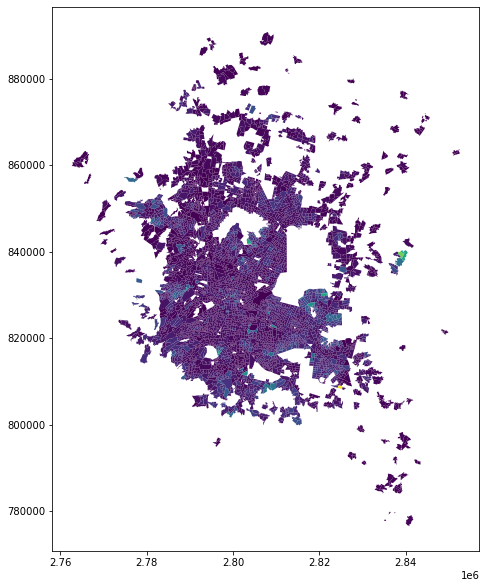

In [30]:
agebs_zmvm.plot('P3YM_HLI', figsize=(10, 10))

Aunque no es muy claro, parece que sí se puede observar algún patrón espacial en la distribución de los hablantes de lengua indígena. Exploremos ahora si estos patrones son más claros calculando algunas métricas de segregación.

## Índices aespaciales

Primero vamos a calcular un índice global que nos indica, a lo largo de todo el espacio, qué tan segregada está la variable de interés. La disimilaridad mide que tan homogéneamente están distribuidos dos grupos a lo largo de nuestras unidades de análisis. 

$$\frac{1}{2} \sum_{i=1}^N  \left| \frac{a_i}{A} - \frac{b_i}{B} \right|$$

$a_1$: población del grupo $A$ en el área $i$

$A$: población total del grupo $A$

$b_i$: población del grupo $B$ en al área $i$

$B$: total de población del grupo $B$

El valor del índice va de $0$, no hay disimilaridad, a $1$, segregación completa

In [31]:
from segregation.singlegroup import Dissim
dissim = Dissim(agebs_zmvm, group_pop_var='P3YM_HLI', total_pop_var='POBTOT')
dissim.statistic

0.3134440887088542

## Índices espaciales

Aquí vamos a calcular algunos índices de segregación global que explotan la estructura espacial (a través de la distancia euclidiana)

### TODO: describir los índices

In [35]:
from segregation.singlegroup import AbsoluteCentralization, Gini
# Centralización absoluta
cent = AbsoluteCentralization(agebs_zmvm, group_pop_var='P3YM_HLI', total_pop_var='POBTOT')
# Gini aespacial
aspatial_gini = Gini(agebs_zmvm, group_pop_var='P3YM_HLI', total_pop_var='POBTOT')
# Gini generalizado
gen_spatialgini = Gini(agebs_zmvm, group_pop_var='P3YM_HLI', total_pop_var='POBTOT', distance=2000)
print(f'Centralización absoluta: {cent.statistic}')
print(f'Gini aespacial: {aspatial_gini.statistic}')
print(f'Gini generalizado: {gen_spatialgini.statistic}')

Centralización absoluta: 0.22301602185234515
Gini aespacial: 0.4313745850012524
Gini generalizado: 0.2903976416893668


## Índices locales

En lugar de preguntarnos la segregación global de una población, podemos preguntarnos qué tan segregada está con respecto a su entorno local, es decir, detectar _enclaves_ locales de nuestra población objetivo. Pueden pensar que los índices globales son similares a la I de Moran, mientras que los índices locales son similares a los mapas de LISA

### Cociente de localización

El Cociente de Loaclización (LQ) es la razón de la proporción del grupo de interés en cada área contra la razón del grupo de interés en toda el área de estudio. De esta forma estamos midiendo qué tan concentrada esta la población en cada área con respecto a la concentración total.

In [51]:
from segregation.local import MultiLocationQuotient, MultiLocalDiversity, MultiLocalEntropy, \
                              MultiLocalSimpsonInteraction, MultiLocalSimpsonConcentration, \
                              LocalRelativeCentralization

lq = MultiLocationQuotient(agebs_zmvm, ['POBTOT', 'P3YM_HLI'])
lq.statistics

array([[0.99050583, 1.65851739],
       [1.00870123, 0.39648119],
       [1.0030349 , 0.78949912],
       ...,
       [1.0034728 , 0.75912628],
       [1.00737293, 0.48861223],
       [1.01048565, 0.2727138 ]])

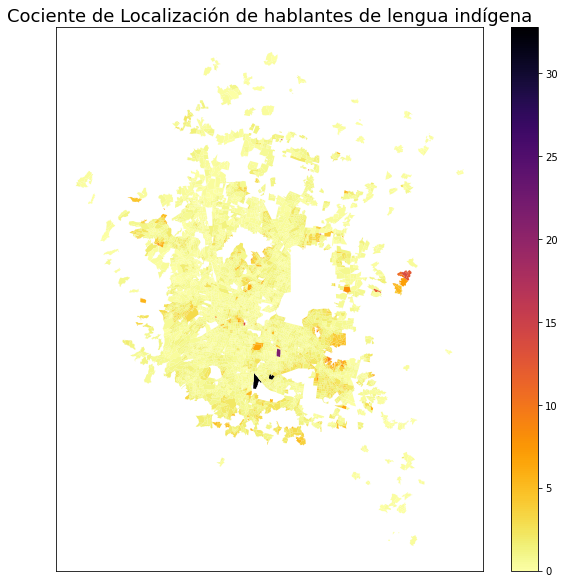

In [46]:
agebs_zmvm['LQ_P3YM_HLI'] = lq.statistics[:,1]
ax = agebs_zmvm.plot(column = 'LQ_P3YM_HLI',
                     cmap = 'inferno_r',
                     legend = True,
                     figsize=(10, 10))
ax.set_title('Cociente de Localización de hablantes de lengua indígena', fontsize = 18)
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('white')

## Centralización Local

In [52]:
cl = LocalRelativeCentralization(agebs_zmvm, 'P3YM_HLI', 'POBTOT')
agebs_zmvm['cl'] = cl.statistics
# ax = agebs_zmvm.plot(column = 'cl', cmap = 'inferno_r', legend = True, figsize = (10,10))
# ax.set_title("Centralización Local", fontsize = 25)

IndexError: positional indexers are out-of-bounds

In [50]:
agebs_zmvm

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,geometry,index_right,id,POBTOT,P3YM_HLI,LQ_P3YM_HLI
0,0901000011716,09,010,0001,1716,"POLYGON ((2787237.541 816989.461, 2787288.728 ...",0,1,7042,170.0,1.658517
1,0901000012150,09,010,0001,2150,"POLYGON ((2794154.458 823013.444, 2794155.774 ...",0,1,4588,26.0,0.396481
2,0901000011133,09,010,0001,1133,"POLYGON ((2795690.723 820050.788, 2795684.238 ...",0,1,2203,25.0,0.789499
3,0901000011307,09,010,0001,1307,"POLYGON ((2792584.475 815678.668, 2792624.325 ...",0,1,2914,86.0,2.016991
4,0901000010281,09,010,0001,0281,"POLYGON ((2788845.392 823526.074, 2788840.549 ...",0,1,237,6.0,1.737288
...,...,...,...,...,...,...,...,...,...,...,...
5753,151250001004A,15,125,0001,004A,"POLYGON ((2808390.934 857912.251, 2808614.795 ...",0,1,1020,4.0,0.274844
5754,1512500010016,15,125,0001,0016,"POLYGON ((2808318.468 857265.867, 2808312.961 ...",0,1,2686,15.0,0.390745
5755,1512500010020,15,125,0001,0020,"POLYGON ((2807637.181 858200.578, 2807639.598 ...",0,1,3209,35.0,0.759126
5756,1512500070054,15,125,0007,0054,"POLYGON ((2806574.677 856458.207, 2806484.183 ...",0,1,1573,11.0,0.488612
